# Length vs. Time of Elongated Bubbles

Per the request and recommendation of Prof. Howard Stone during our conversation on December 15, 2021, I will plot the length of elongated bubbles vs. time. We expect the bubbles to grow like cylinders, following a different growth behavior than a sphere.

I will investigate different ways of collapsing the data. First, I simply "stitched" the data together, such that each trajectory overlaps with another.

Next, I will compare the growth profiles with those predicted by different growth regimes. First, I compared the data to a power law. It appeared that the data fit to a power law of $t^{3/2}$ after using the "stitching" technique described above, so I tried to fit the data to such a model but observed poor agreement. Second, I noticed the data matched an exponential curve at larger bubble sizes, which is indicative of constant flux along the entire surface of the bubble (*i.e.*, negligible depletion of CO$_2$ outside the bubble). I fit the data to such a model and saw better agreement.

In [1]:
dp = 10E6 # Pa
Lcap = 0.1 # m
R = 20E-6 # m
L = 100E-6 # m
eta = 0.025 # Pa.s
U = 1/4*dp/Lcap*(R*L)/eta
print(U)


2.0


In [2]:
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

# data parameters
data_dir = 'input/'
# loads data from three videos taken at different lengths along channel on July 20, 2021
data_paths = ['ppg_co2_50000_000-7_050_0302_90_20_78/test1/data/f_0_1_34932_dist.pkl', # 20x requires different pix_per_um
             'ppg_co2_40000_001-1_050_0226_79_04_10/std/data/f_0_1_39922_dist.pkl',
             'ppg_co2_40000_001-1_050_0226_79_04_9/std/data/f_0_1_39922_dist.pkl'
             ]

# parameters for filtering out objects that are not elongated bubbles
thresh_aspect_ratio = 3 # elongated bubbles must have minimum aspect ratio
thresh_frames = 6 # elongated bubbles are only interesting if we observe multiple frames
inner_stream_frac = 0.4 # fraction of inner stream width that bubble should span to be considered
um_2_m = 1E-6

### Useful Functions

In [3]:
def apply_time_shift(compute_t_shift_fn, i, t_arr, L_arr, 
                     t_arr_list_sorted, L_arr_list_sorted):
    """Applies time shift to help collapse data."""
     # computes shift in time to match previous curve at beginning
    if i == 0:
        t_shift = 0
    else:
        t_arr_prev = t_arr_list_sorted[i-1]
        L_arr_prev = L_arr_list_sorted[i-1]
        
        # the time at this index is the shift we will add to the current bubbles timeline
        t_shift = compute_t_shift_fn(L_arr_prev, L_arr[0], t_arr_prev) 

    # shifts time and saves shifted time series to variable
    t_arr += t_shift - t_arr[0]
    
    return t_arr

def compute_h(obj, pix_per_um):
    """Computes height (vertical extent) of object."""
    # computes height [um]
    bbox_list = obj['props_raw']['bbox']
    h_list = [(r_hi - r_lo)/pix_per_um for r_lo, _, r_hi, _ in bbox_list]
    idx_valid = np.logical_not(obj['props_raw']['on border'])
    
    return np.asarray(h_list)[idx_valid]

def compute_max_aspect_ratio(obj):
    """Computes the maximum aspect ratio of the object assuming it is wider than it is tall."""
    bbox_list = obj['props_raw']['bbox']
    h_max = np.max([r_hi - r_lo for r_lo, _, r_hi, _ in bbox_list]) 
    L_max = np.max([c_hi - c_lo for _, c_lo, _, c_hi in bbox_list])
    
    return L_max / h_max

def compute_t_shift(L_arr_prev, L0, t_arr_prev):
    """Computes time shift to match first point L0 to a point on the previous growth profile L_arr_prev."""
    # finds index where width of previous bubble was 
    # closest to initial width of current bubble
    idx = np.argmin(np.abs(L_arr_prev - L0))
    # the time at this index is the shift we will add to the current bubbles timeline
    t_shift = t_arr_prev[idx]
    
    return t_shift

def compute_t_shift_model_t32(L_arr_prev, L0, t_arr_prev):
    """Computes shift in time to match model."""
    t = np.linspace(0, 1E5, 100000) # time step every microsecond
    L_model = t**1.5/1.2E3
    idx = np.argmin(np.abs(L_model - L0))
    t_shift = t[idx]
    
    return t_shift


def compute_t_shift_model_texp(L_arr_prev, L0, t_arr_prev):
    """Computes shift in time to match model."""
    t = np.linspace(0, 1E5, 100000) # time step every microsecond
    L_model = 70*np.exp(t/2500)
    idx = np.argmin(np.abs(L_model - L0))
    t_shift = t[idx]
    
    return t_shift
    

def compute_t_w(obj, pix_per_um, fps, s_2_us=1E6):
    """Computes time and width (horizontal extent) of object over time in [um] and [us], respectively."""
    # computes width [um]
    bbox_list = obj['props_raw']['bbox']
    L_list = [(c_hi - c_lo)/pix_per_um for _, c_lo, _, c_hi in bbox_list]
    # computes time [us]
    n_frames = len(bbox_list)
    t_arr = np.arange(n_frames)/fps*s_2_us

    # identifies valid windows where bubble is not on border
    idx_valid = np.logical_not(obj['props_raw']['on border'])

    # formats arrays for plotting
    t_arr = t_arr[idx_valid]
    L_arr = np.array(L_list)[idx_valid]
    
    return t_arr, L_arr


def compute_t_3_dims(obj, pix_per_um, fps, s_2_us=1E6):
    """Computes time and width (horizontal extent) of object over time in [um] and [us], respectively."""
    # computes width [um]
    bbox_list = obj['props_raw']['bbox']
    L_list = [(c_hi - c_lo)/pix_per_um for _, c_lo, _, c_hi in bbox_list]
    D_list = [(r_hi - r_lo)/pix_per_um for r_lo, _, r_hi, _ in bbox_list]
    Dv_list = [(np.pi*(D/2)**2*L)**(1/3) for L, D in zip(L_list, D_list)]
    # computes time [us]
    n_frames = len(bbox_list)
    t_arr = np.arange(n_frames)/fps*s_2_us

    # identifies valid windows where bubble is not on border
    idx_valid = np.logical_not(obj['props_raw']['on border'])

    # formats arrays for plotting
    t_arr = t_arr[idx_valid]
    L_arr = np.array(L_list)[idx_valid]
    D_arr = np.array(D_list)[idx_valid]
    Dv_arr = np.array(Dv_list)[idx_valid]
    
    return t_arr, L_arr, D_arr, Dv_arr

def get_polyol(vid_name):
    """Gets name of polyol from video name."""
    i1 = vid_name.find('_')
    i2 = vid_name[i1+1:].find('_')
    
    return vid_name[:i1+1+i2]

def get_number(vid_name):
    """Gets number of video (order in which taken) from video name."""
    i = vid_name.rfind('_')
    
    return int(vid_name[i+1:-4])

def legend(ax):
    """Adds legend outside box."""
    # puts legend outside of plot box
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width, box.height])
    legend_x = 1
    legend_y = 0.5
    ax.legend(loc='center left', fontsize=14, bbox_to_anchor=(legend_x, legend_y))
    
def load_data(data_dir, filename):
    """Loads data from directory and filepath bitwise."""
    filepath = os.path.join(data_dir, filename)
    with open(filepath, 'rb') as f:
        data = pkl.load(f)
        
    return data

# plotting
def plot_length_vs_time(t, w, ax=None, loglog=False, ax_fs=18, t_fs=20, label='',
                        lw=2, tk_fs=16, title='Length of Bubble vs. Time'):
    """Plots bubble length (longest extent) over time."""
    # creates figure
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    # plots data
    ax.plot(t, w, lw=lw, label=label)
    # formats plot
    ax.set_xlabel(r'time [$\mu$s]', fontsize=ax_fs)
    ax.set_ylabel(r'head-to-tail distance [$\mu$m]', fontsize=ax_fs)
    ax.set_title(title, fontsize=t_fs)
    ax.tick_params(axis='both', labelsize=tk_fs)
    # plot on log-log axes?
    if loglog:
        ax.set_xscale('log')
        ax.set_yscale('log')
        
    return ax

def plot_3_dims_vs_time(t, L, D, Dv, ax=None, loglog=False, ax_fs=18, t_fs=20, label='',
                        lw=2, tk_fs=16, title='Length of Bubble vs. Time'):
    """Plots bubble length L, diameter d, and cube-root of volume Dv."""
    # creates figure
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    # plots data
    ax.plot(t, L, lw=lw, label=label + ' (L)') # length
    ax.plot(t, D, lw=lw, label=label + ' (d)') # diameter
    ax.plot(t, Dv, lw=lw, label=label + r' ($V^{1/3}$)') # cube-root of volume
    # formats plot
    ax.set_xlabel(r'time [$\mu$s]', fontsize=ax_fs)
    ax.set_ylabel(r'size [$\mu$m]', fontsize=ax_fs)
    ax.set_title(title, fontsize=t_fs)
    ax.tick_params(axis='both', labelsize=tk_fs)
    # plot on log-log axes?
    if loglog:
        ax.set_xscale('log')
        ax.set_yscale('log')
        
    return ax

## Plots Length vs. Time

I begin by filtering the objects detected in the analysis to only include elongated bubbles. I then plot their length (longest extent) over time, where time is measured from their first observation. I omit measurements of length taken when the bubble was not fully within the field of view.

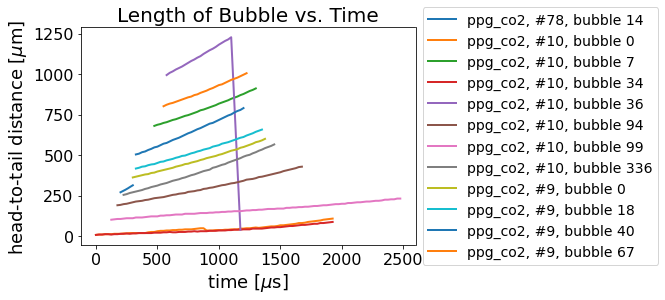

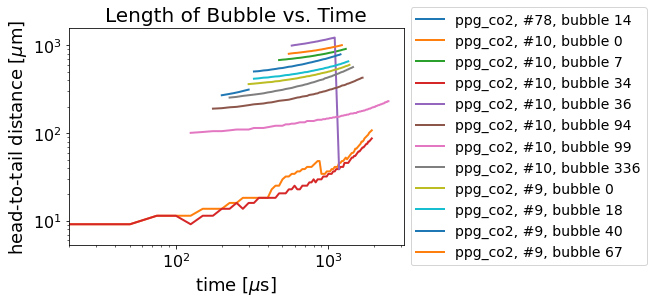

In [4]:
# initializes axes for plots
ax1 = None # linear-linear
ax2 = None # log-log

# initializes lists to store data
t_data = []
L_data = []
num_data = []
obj_data = []

# collects data from all data files
for data_path in data_paths:
    # loads data from path
    data = load_data(data_dir, data_path)
        
    # initializes lists to store plot data
    t_arr_list = []
    L_arr_list = []
    num_list = []
    obj_list = []
        
    # loads relevant metadata (pixel to micron conversion)
    pix_per_um = data['metadata']['object_kwargs']['pix_per_um']
    fps = data['metadata']['fps']
    R_i = data['metadata']['object_kwargs']['R_i']
    inner_stream_width = 2*R_i

    # initializes list of indices of elongated bubbles
    inds_elong = []
    for i in range(len(data['objects'])):
        obj = data['objects'][i]
        # computes maximum height and width of each object observe
        max_aspect_ratio = compute_max_aspect_ratio(obj)
        # considers bubbles elongated if the width:height ratio is
        # greater than the minimum aspect ratio specified 
        if (max_aspect_ratio <= thresh_aspect_ratio):
            continue
            
        t_arr, L_arr = compute_t_w(obj, pix_per_um, fps)
        h_arr = compute_h(obj, pix_per_um)
        
        # skips bubbles that do not appear in consecutive frames, did not exit frame, or
        # are too thin (should be at least half of inner stream width)
    
        if (len(t_arr) < thresh_frames) or (np.sum(obj['props_proc']['consecutive']) == 0) \
            or (np.sum(obj['props_proc']['exited']) == 0) or \
            (np.max(h_arr)*um_2_m < inner_stream_frac*inner_stream_width):
            continue
        else:
            # stores time and width arrays
            t_arr_list += [t_arr]
            L_arr_list += [L_arr]
            # stores bubble number
            num_list += [i]
            # stores object
            obj_list += [obj]
            
        # creates plot label
        label = get_polyol(data['metadata']['vid_name']) + \
                ', #{0:d}'.format(get_number(data['metadata']['vid_name'])) + \
                ', bubble {0:d}'.format(i)
        
        # plots length vs time
        ax1 = plot_length_vs_time(t_arr, L_arr, ax=ax1, loglog=False, label=label)
        ax2 = plot_length_vs_time(t_arr, L_arr, ax=ax2, loglog=True, label=label)
        
    # stores data from path in master lists
    t_data += [t_arr_list]
    L_data += [L_arr_list]
    num_data += [num_list]
    obj_data += [obj_list]
    
# adds legends
legend(ax1)
legend(ax2)

While the data do not obviously collapse, I observe that the slope of the growth profile increases with the size of the bubble, *i.e.*, the bubbles are elongating faster as they grow bigger. 

Perhaps I can shift the time of these growth profiles to collapse the data better, where larger bubbles are shifted to later times?

## Try Shifting Time to "Superpose" Curves

I will shift the starting time to get each curve to match the previous at its starting point. Hopefully this manipulation provides a new perspective on the data.

### Sort Data by Bubble Length

To simplify time shifting, I will first order the the measurements by the length of the bubble observed in increasing order.

In [5]:
def sort_fn(t_L_num_arr):
    """Function to sort list of 3-tuples of time, length, and bubble number."""
    t_arr, L_arr, num = t_L_num_arr
    return L_arr[0]

# creates lists to store all data temporarily
t_tmp = []
L_tmp = []
num_tmp = []
_ = [t_tmp.extend(t) for t in t_data]
_ = [L_tmp.extend(w) for w in L_data]
_ = [num_tmp.extend(num) for num in num_data]

# organizes lists for sorting
t_L_num_arr = [(t_arr, L_arr, num) for t_arr, L_arr, num in zip(t_tmp, L_tmp, num_tmp)]
# sorts data by initial bubble length
t_L_num_arr.sort(key=sort_fn)
# parses sorted data
t_arr_list_sorted, L_arr_list_sorted, num_list_sorted = zip(*t_L_num_arr)

print('Data sorted.')

Data sorted.


### Shifts Data in Time and Plots Growth Curves

Hypothesis: shifting data will reveal collapse onto a power law.

In [6]:
def plot_w_t_shift(compute_t_shift_fn, data, t_arr_list_sorted, 
                   L_arr_list_sorted, num_list_sorted):
    """Plots data with computed t shift."""

    # initializes axes for plotting
    ax1 = None
    ax2 = None
    ax3 = None

    # plots length vs. time with shifted time
    for i in range(len(t_arr_list_sorted)):
        t_arr = t_arr_list_sorted[i]
        L_arr = L_arr_list_sorted[i]
        num = num_list_sorted[i]

        # applies time shift to array of observation times
        t_arr = apply_time_shift(compute_t_shift_fn, i, t_arr, L_arr, 
                                 t_arr_list_sorted, L_arr_list_sorted)    

         # creates plot label
        label = get_polyol(data['metadata']['vid_name']) + \
                ', #{0:d}'.format(get_number(data['metadata']['vid_name'])) + \
                ', bubble {0:d}'.format(num)

        # plots length vs time
        ax1 = plot_length_vs_time(t_arr, L_arr, ax=ax1, loglog=False, label=label)
        ax2 = plot_length_vs_time(t_arr, L_arr, ax=ax2, loglog=True, label=label)
        ax3 = plot_length_vs_time(t_arr, L_arr, ax=ax3, loglog=True, label=label)

    # makes axes of log-log plot equal in aspect ratio
    # ax2.axis('equal')
    ax2.set_xlim([1E3, 2E4])
    ax2.set_ylim([1E2, 2E3])
    ax3.set_xscale('linear')


    # plots dashed line for slope reference
    m = 1.5
    x_line = [1000, 2000, 4000, 8000]
    y_line = [(x/1000)**m*100 for x in x_line]
    ax2.plot(x_line, y_line, 'k--', label='L ~ t^{0:.1f}'.format(m))

    y_line = [70*np.exp(x/2500) for x in x_line]
    ax3.plot(x_line, y_line, 'k--', label='exponential')
    ax3.set_ylim([1E2, 2E3])


    # adds legends
    legend(ax1)
    legend(ax2)
    legend(ax3)

First, compute time shift using "stitching," where I make the first point of each growth profile match the point with the most similar bubble length on the previous growth profile (previous meaning the growth profile of the next smallest bubble).

I will plot the data on linear-linear, log-log, and semilogy axes.

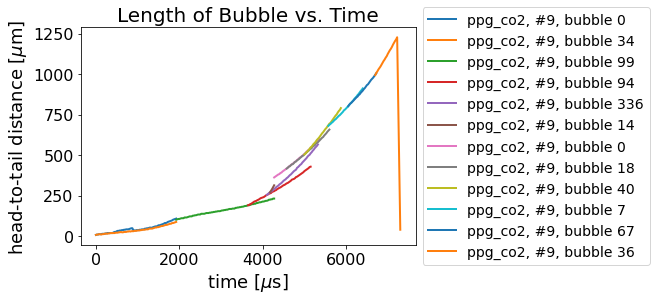

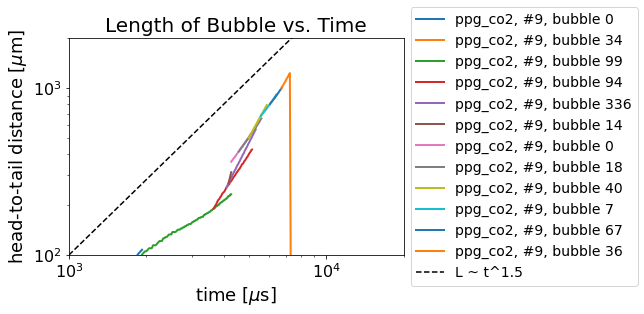

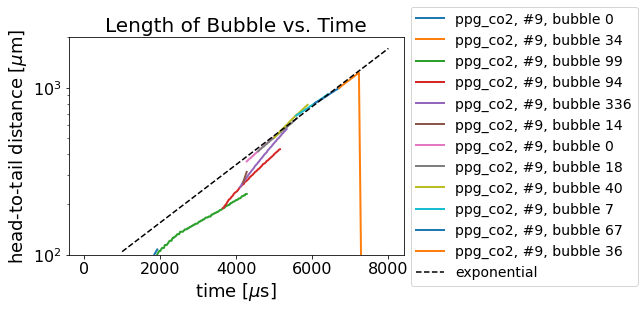

In [7]:
plot_w_t_shift(compute_t_shift, data, t_arr_list_sorted, 
                   L_arr_list_sorted, num_list_sorted)

It appears that the larger bubbles might match either a $t^{3/2}$ power-law or $e^t$ exponential model. I will examine how well these describe the data below. 

#### Power-law Model

Next, I will compute the time shift that yields the closest match of the first data point to a $t^{3/2}$ power-law model whose parameters I specified myself to match the data as best as I thought.

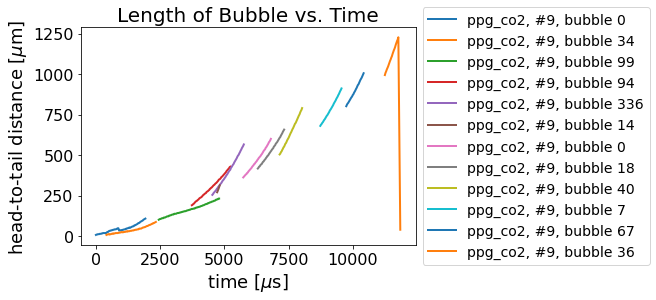

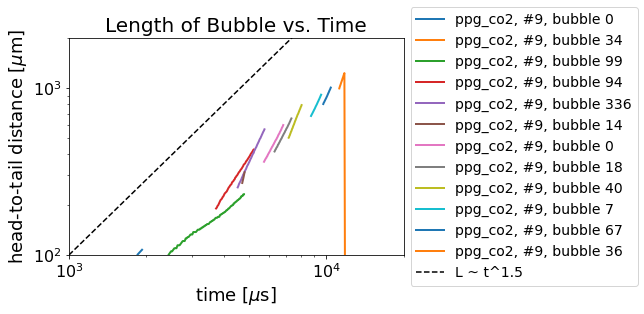

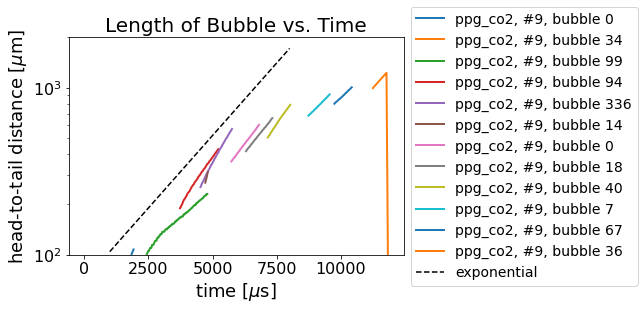

In [8]:
plot_w_t_shift(compute_t_shift_model_t32, data, t_arr_list_sorted, 
                   L_arr_list_sorted, num_list_sorted)

The power-law model that I specified did not collapse the data.

#### Exponential Model

Next, I will compute the time shift that yields the closest match of the first data point to a $e^t$ power-law model whose parameters I specified myself to match the data as best as I thought.

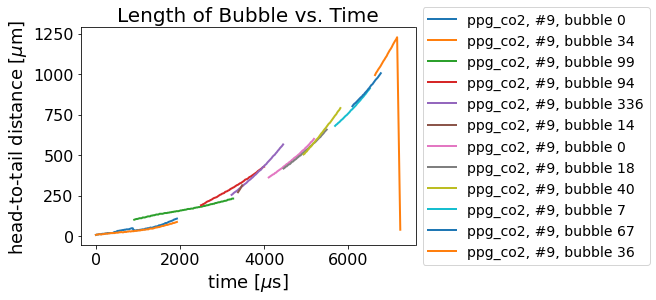

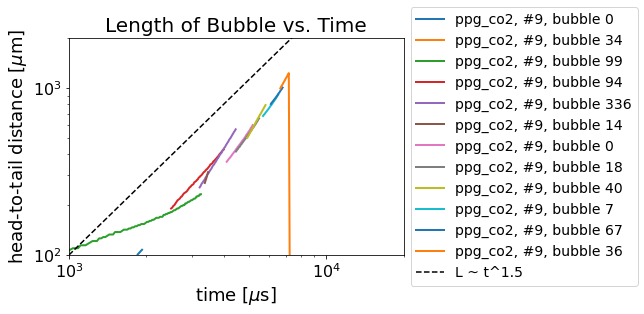

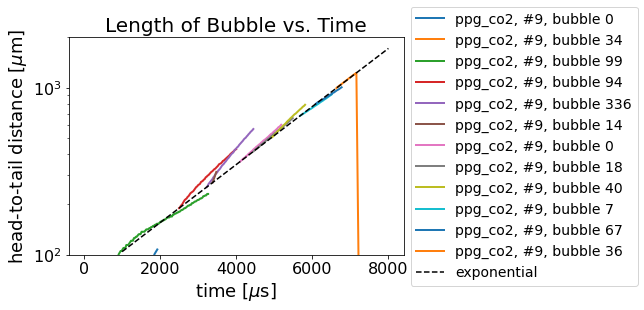

In [9]:
plot_w_t_shift(compute_t_shift_model_texp, data, t_arr_list_sorted, 
                   L_arr_list_sorted, num_list_sorted)

The data collapse reasonably well onto the exponential model, although some measurements (*e.g.*, bubble 336) deviate significantly. These still appear as straight lines on the semilogy axes, which suggests that they might be growing with a faster exponential.

## Consider Different Experiments Separately

During my meeting with her on January 5, 2022, Julie observed that the measurements of the bubble length over time collapse onto three different curves. Because I am collecting the data from three different videos, I wonder if each curve corresponds to a different video. To test this hypothesis, I will plot the growth curves from each video on a separate plot.

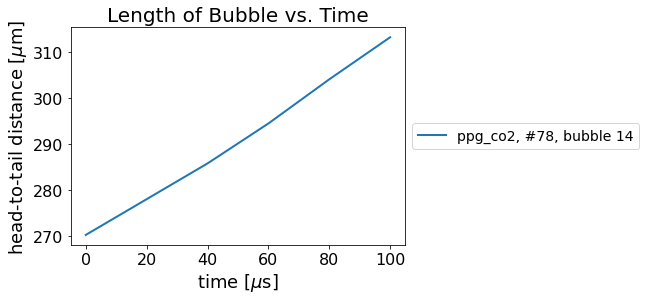

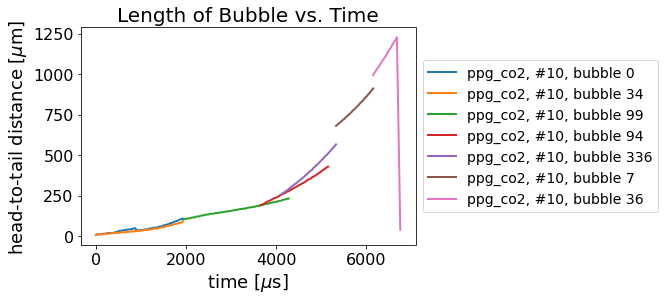

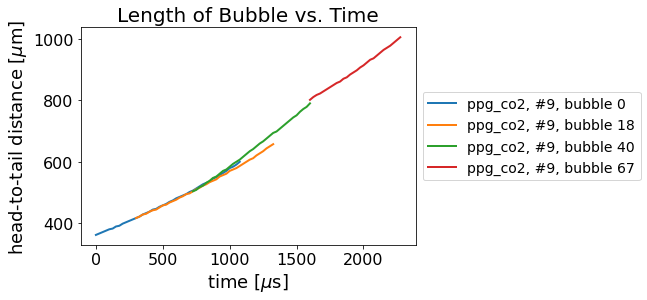

In [10]:
# plots length vs. time with shifted time
for i in range(len(data_paths)):
    # loads data from path
    data = load_data(data_dir, data_paths[i])
        
    # loads data
    t_arr = t_data[i]
    L_arr = L_data[i]
    num_list = num_data[i]
    
    # sorts data
    t_L_num_arr = list(zip(t_arr, L_arr, num_list))
    t_L_num_arr.sort(key=sort_fn)
    t_arr_list_sorted, L_arr_list_sorted, num_list_sorted = zip(*t_L_num_arr) # unzips time and width
    
    # initializes plot axes
    ax = None
    
    for j in range(len(t_L_num_arr)):
        t_arr = t_arr_list_sorted[j]
        L_arr = L_arr_list_sorted[j]
        num = num_list_sorted[j]

        # computes shift in time to match previous curve at beginning
        t_arr = apply_time_shift(compute_t_shift, j, t_arr, L_arr, 
                                 t_arr_list_sorted, L_arr_list_sorted)

         # creates plot label
        label = get_polyol(data['metadata']['vid_name']) + \
                ', #{0:d}'.format(get_number(data['metadata']['vid_name'])) + \
                ', bubble {0:d}'.format(num)

        # plots length vs time
        ax = plot_length_vs_time(t_arr, L_arr, ax=ax, loglog=False, label=label)
        
        # adds legend
        legend(ax)

Given the sharp difference in slope for bubbles 7 and 8 in video 10, as well as for bubbles 2 and 3 in video 9, the **bubbles observed within a single video do not appear to collapse on the same curve either.**

#### Bubble Notes
In video 9:
- 0: lone bubble
- 18: lone bubble (40 enters 350 frames later)
- 40: lone bubble (18 exits 350 frames before)
- 67: lone bubble

In video 10:
- 0: leading bubble in front of 1 and 2 (nucleates in FOV)
- 7: lone bubble
- 34: lone bubble (starts small)
- 36: lone bubble
- 94: leading bubble in front of 99 (grows faster)
- 99: trailing bubble behind 94 (grows slower)
- 336: lone bubble (grows faster than 94 or 99)

### Fit Bubble Growth to More Complex Model

**Probably less relevant given the poor fit to the $t^{3/2}$ observed earlier.**

I propose the model $L(t) = a(t + t_0)^{3/2}$ to describe the growth in the length of the bubble observed here, where $L(t=0) = at_0^{3/2}$. It appears to match the data after applying a crude time shift. Now I want to see if the data collapse to this model.

In [11]:
import scipy.optimize

def test_model(model_fn, params0_fn, t_arr_list_sorted, 
               L_arr_list_sorted, num_list_sorted):
    """Tests a model to fit to data. Make sure t0 is first parameter."""
    # initializes axes for plotting
    ax1 = None
    ax2 = None
    ax3 = None

    # plots length vs. time with shifted time
    for i in range(len(t_arr_list_sorted)):
        t_arr = t_arr_list_sorted[i]
        L_arr = L_arr_list_sorted[i]
        num = num_list_sorted[i]


        params0 = params0_fn(t_arr, L_arr)

        try:
            popt, pcov = scipy.optimize.curve_fit(model_fn, t_arr, L_arr/L_arr[0], params0)
            t0 = popt[0]
            # shifts time
            t_arr += t0

             # creates plot label
            label = get_polyol(data['metadata']['vid_name']) + \
                    ', #{0:d}'.format(get_number(data['metadata']['vid_name'])) + \
                    ', bubble {0:d}'.format(num)

            # plots length vs time
            ax1 = plot_length_vs_time(t_arr, L_arr, ax=ax1, loglog=False, label=label)
            ax2 = plot_length_vs_time(t_arr, L_arr, ax=ax2, loglog=True, label=label)
            ax3 = plot_length_vs_time(t_arr, L_arr, ax=ax3, loglog=True, label=label)

        except:
            print('Failed to fit.')

    # makes axes of log-log plot equal in aspect ratio
    # ax2.axis('equal')
    ax2.set_xlim([1E3, 2E4])
    ax2.set_ylim([1E2, 2E3])
    ax3.set_xscale('linear')

    t_fit = np.linspace(0, 5E-3, 100)
    L_fit = t_fit**1.5*0.85
    ax1.plot(t_fit*1E6, L_fit*1E6, 'k--', label='fit')

    # plots dashed line for slope reference
    m = 1.5
    x_line = [1000, 2000, 4000, 8000]
    y_line = [(x/1000)**m*100 for x in x_line]
    ax2.plot(x_line, y_line, 'k--', label='L ~ t^{0:.1f}'.format(m))

    y_line = [200*np.exp(x/2500) for x in x_line]
    ax3.plot(x_line, y_line, 'k--', label='exponential')
    ax3.set_ylim([1E2, 2E3])

    # adds legends
    legend(ax1)
    legend(ax2)
    legend(ax3)

#### Two-parameter $t^{3/2}$ Model

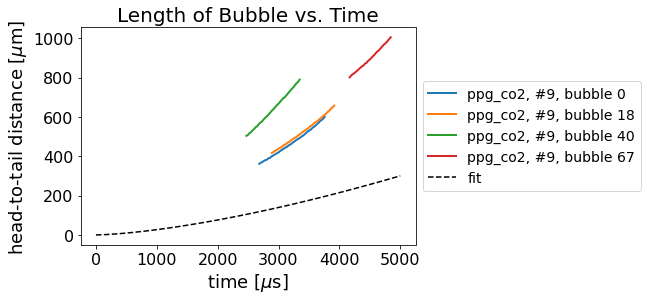

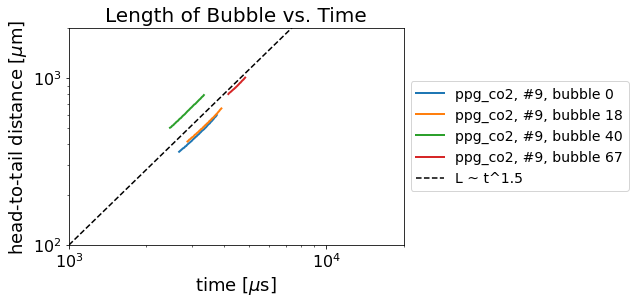

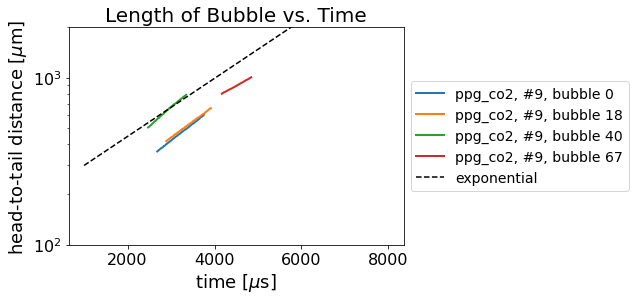

In [12]:
def t32_model_2p(t, t0, a):
    """Model of length of bubble vs. time for t^3/2 growth."""
    return a*(t + t0)**1.5

def params0_2p(t_arr, L_arr):
    """Computes guess for 2-parameter model."""
    # fits model to data
    a0 = L_arr[0]/t_arr[-1]**1.5
    t0 = t_arr[-1]
    return (t0, a0)


test_model(t32_model_2p, params0_2p, t_arr_list_sorted, 
               L_arr_list_sorted, num_list_sorted)

The data don't collapse onto the model well.

#### One-parameter $t^{3/2}$  Model

Now I will specify the coefficient of the model to try to reduce variability in the fit.

C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


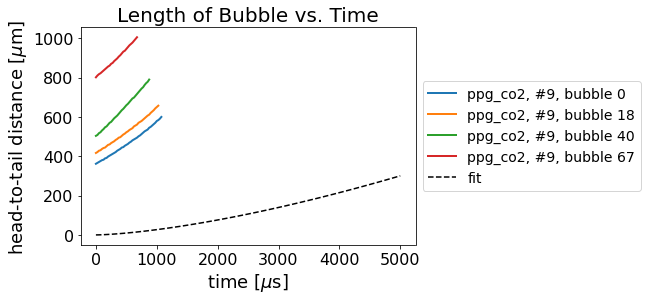

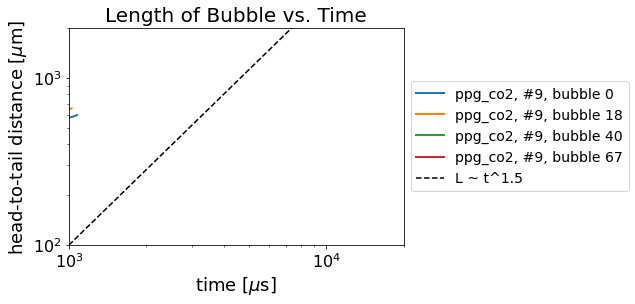

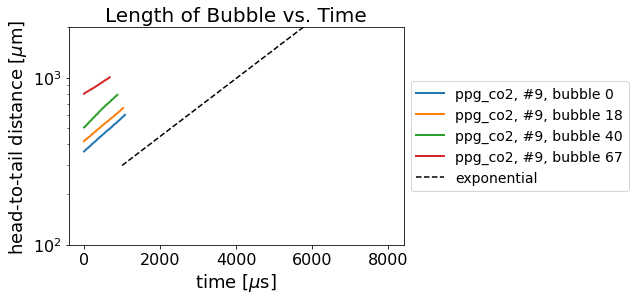

In [13]:
def t32_model_1p(t, t0, a=0.85):
    """Model of length of bubble vs. time for t^3/2 growth."""
    return a*(t + t0)**1.5

def params0_1p(t_arr, L_arr, a=0.85):
    """Computes guess for 2-parameter model."""
    t0 = (L_arr[0]/a)**(2/3)
    return t0

test_model(t32_model_1p, params0_1p, t_arr_list_sorted, 
               L_arr_list_sorted, num_list_sorted)

The fit completely fails, choosing negative time shifts that do not lead to any collapse.

#### Can the correction due to decreasing pressure produce $t^{3/2}$ scaling for length?

Based on Prof. Howard Stone's suggestion, I derived the $t^{3/2}$ term in the Taylor approximation of the predicted growth in bubble length assuming a cylindrical bubble that grows by diffusion through the caps according to Fick's Law (1D version of the Epstein-Plesset model).

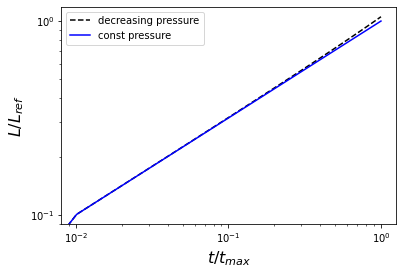

In [14]:
# dimensionless time
tau = np.linspace(0, 1, 100)
# fraction by which pressure changes within FOV
a = 0.05

# length of bubble based on cylindrical bubble growing from ends
L = np.sqrt(tau)/(1-a*tau) # 1 - a*tau gives correction due to decreasing pressure

# plots predictions
plt.plot(tau, L, 'k--', label='decreasing pressure')
plt.plot(tau, np.sqrt(tau), 'b', label='const pressure')

plt.xlabel(r'$t/t_{max}$', fontsize=16)
plt.ylabel(r'$L/L_{ref}$', fontsize=16)
plt.legend()

plt.xscale('log')
plt.yscale('log')

The $t^{3/2}$ correction due to the pressure is negligible and the behavior dominated by the $t^{1/2}$ term.

### Multiple Dimensions of Length

Does length begin to grow exponentially once it diverges from width?

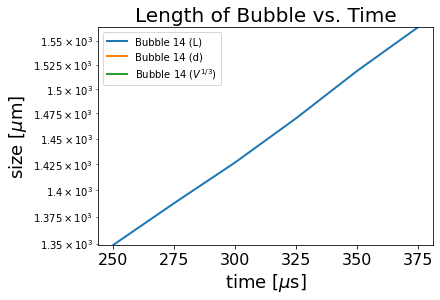

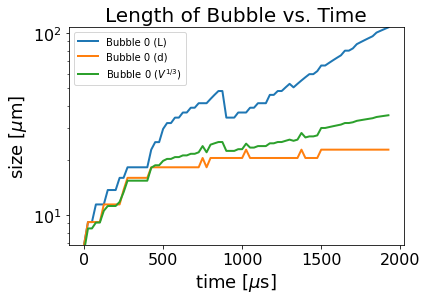

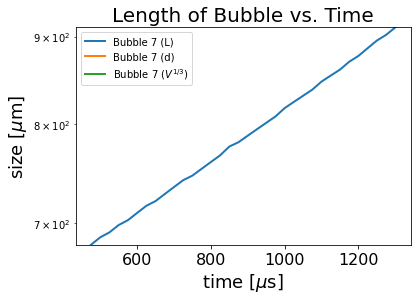

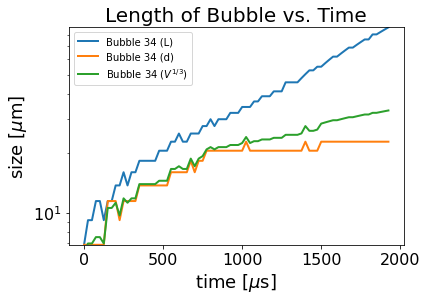

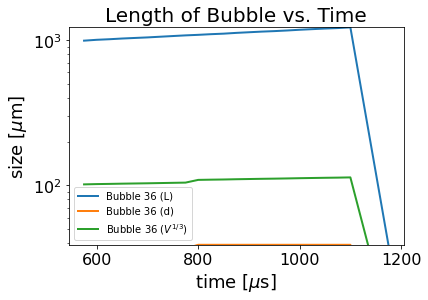

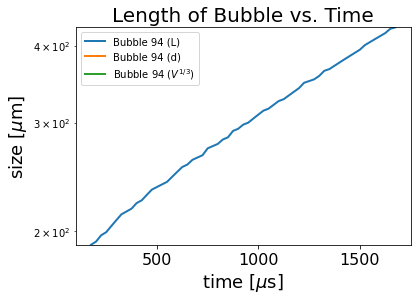

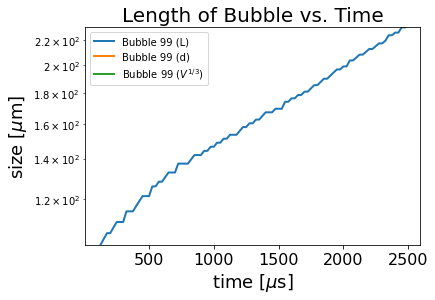

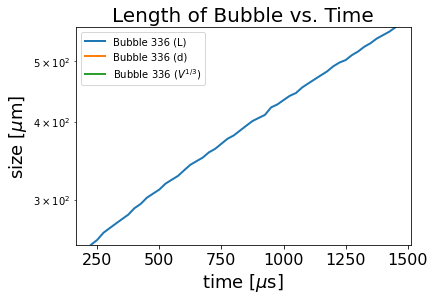

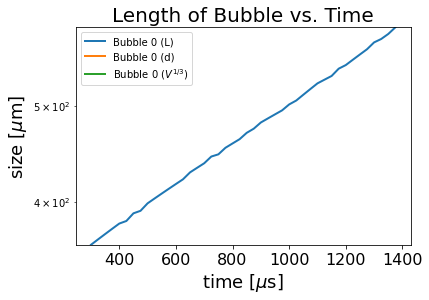

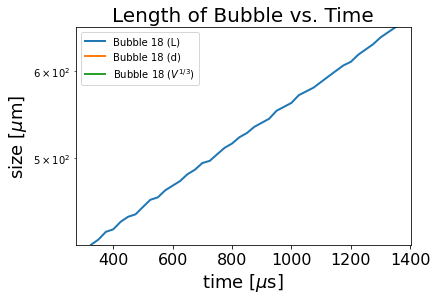

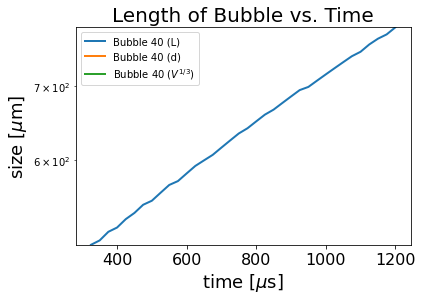

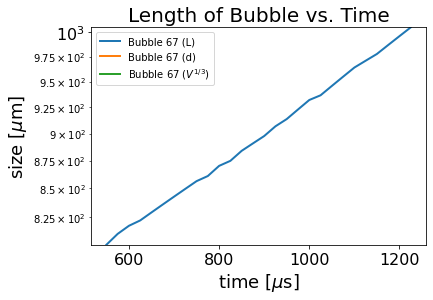

In [15]:
for num_list, obj_list in zip(num_data, obj_data):
    for num, obj in zip(num_list, obj_list):
        t, L, D, Dv = compute_t_3_dims(obj, pix_per_um, fps)
        ax = plot_3_dims_vs_time(t, L, D, Dv, label='Bubble {0:d}'.format(num))
        ax.set_ylim([np.min(L), np.max(L)])
        ax.set_yscale('log')
        ax.legend()

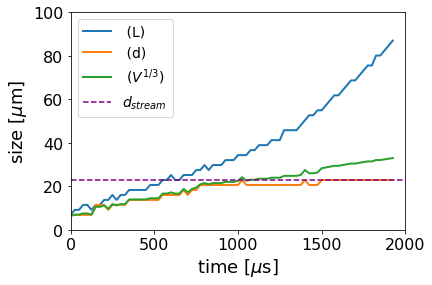

In [16]:
# saves plot of growth of bubble 34 to svg

# parameters
save_dir = '../../REPORTS/20220122_elongated_bubbles/figs/for_inkscape/'
save_name = 'bub_len_sqrt_exp.svg'
vid_num = 1
num = 34
x_lim = [0, 2000]

# plots growth
obj = obj_data[vid_num][np.where(np.asarray(num_data[vid_num]) == num)[0][0]]
t, L, D, Dv = compute_t_3_dims(obj, pix_per_um, fps)
ax = plot_3_dims_vs_time(t, L, D, Dv)
ax.plot(x_lim, [np.max(D), np.max(D)], color='purple', ls='--', ms=0, label=r'$d_{stream}$')
ax.set_ylim([np.min(L), np.max(L)])
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlim(x_lim)
ax.set_ylim([0, 100])
ax.set_title('')
ax.legend(fontsize=14)

# saves figure
plt.savefig(os.path.join(save_dir, save_name), bbox_inches="tight")

C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


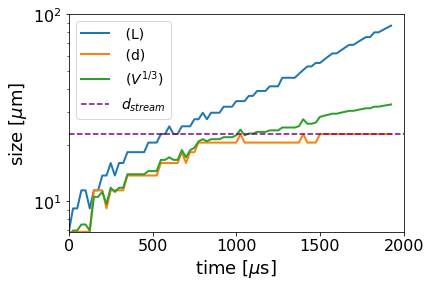

In [17]:
# saves plot of growth of bubble 34 to svg

# parameters
save_dir = '../../REPORTS/20220122_elongated_bubbles/figs/for_inkscape/'
save_name = 'bub_len_sqrt_exp_semilogy.svg'
vid_num = 1
num = 34
x_lim = [0, 2000]

# plots growth
obj = obj_data[vid_num][np.where(np.asarray(num_data[vid_num]) == num)[0][0]]
t, L, D, Dv = compute_t_3_dims(obj, pix_per_um, fps)
ax = plot_3_dims_vs_time(t, L, D, Dv)
ax.plot(x_lim, [np.max(D), np.max(D)], color='purple', ls='--', ms=0, label=r'$d_{stream}$')
ax.set_ylim([np.min(L), np.max(L)])
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(x_lim)
ax.set_ylim([0, 100])
ax.set_title('')
ax.legend(fontsize=14)

# saves figure
plt.savefig(os.path.join(save_dir, save_name), bbox_inches="tight")

How much should the bubble grow if it continues to grow exponentially?

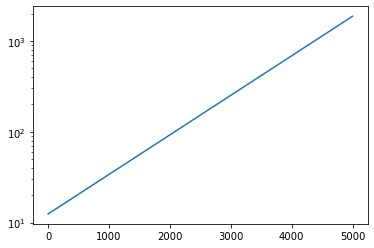

In [18]:
# fits growth between 500 us to 2000 us
t_lo = 500 # [us]
t_hi = 2000 # [us]
idxs = np.where(np.logical_and(t > t_lo, t < t_hi))[0]
a, b = np.polyfit(t[idxs], np.log(L[idxs]), 1)

def L_exp(t, a, b):
    return np.exp(b)*np.exp(a*t)

t_pred = np.linspace(0, 5000, 100)
L_pred = L_exp(t_pred, a, b)

plt.semilogy(t_pred, L_pred)

#### Compare Predicted Growth with Observed Growth

I will shift the observed growth profiles so that the initial times and sizes match the predicted growth in the plot above. If the bubble growth continues as it started, the rest of the observed growth should match the prediction. I think that the observed growth will be slower than the prediction due to depletion of CO2.

(0.0, 500.0)

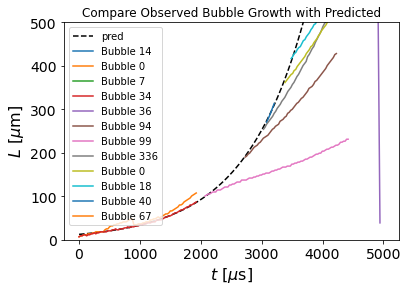

In [19]:
# creates figure
fig = plt.figure()
ax = fig.add_subplot(111)

# plots prediction
ax.plot(t_pred, L_pred, 'k--', label='pred')

# loads data from path
pix_per_um_list = []
for data_path in data_paths:
    data = load_data(data_dir, data_path)
        
    # loads relevant metadata (pixel to micron conversion)
    pix_per_um_list += [data['metadata']['object_kwargs']['pix_per_um']]
    

# loops through each bubble and plots observed growth over predicted growth
for num_list, obj_list, pix_per_um in zip(num_data, obj_data, pix_per_um_list):
    for num, obj in zip(num_list, obj_list):
        t, L, D, Dv = compute_t_3_dims(obj, pix_per_um, fps)
        t_shift = compute_t_shift(L_pred, L[0], t_pred)
        ax.plot(t + t_shift - t[0], L, label='Bubble {0:d}'.format(num))

        
# formats plot
ax.set_xlabel(r'$t$ [$\mu$s]', fontsize=16)
ax.set_ylabel(r'$L$ [$\mu$m]', fontsize=16)
ax.tick_params(axis='both', labelsize=14)
ax.set_title('Compare Observed Bubble Growth with Predicted')
ax.legend()

ax.set_ylim([0, 500])


Note the slower growth starting as soon as 200 $\mu$m in length (ignore bubble 99, which is in the wake of bubble 94 and seems to grow more slowly and travel more slowly, perhaps due to depletion of CO2). This is the same length at which the bubbles begin to slow down.

**The bubbles slow down in velocity and in growth rate concurrently, which suggests that the two are correlated.**